In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib
data_dir = pathlib.Path('All_ECG')

In [3]:
data_dir

PosixPath('All_ECG')

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1932


In [5]:
batch_size = 32
img_height = 360
img_width = 360

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1932 files belonging to 2 classes.
Using 1546 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1932 files belonging to 2 classes.
Using 386 files for validation.


In [8]:
train_ds

<BatchDataset shapes: ((None, 360, 360, 3), (None,)), types: (tf.float32, tf.int32)>

In [9]:
val_ds

<BatchDataset shapes: ((None, 360, 360, 3), (None,)), types: (tf.float32, tf.int32)>

In [10]:
class_names = train_ds.class_names
print(class_names)

['Covid', 'Non_Covid']


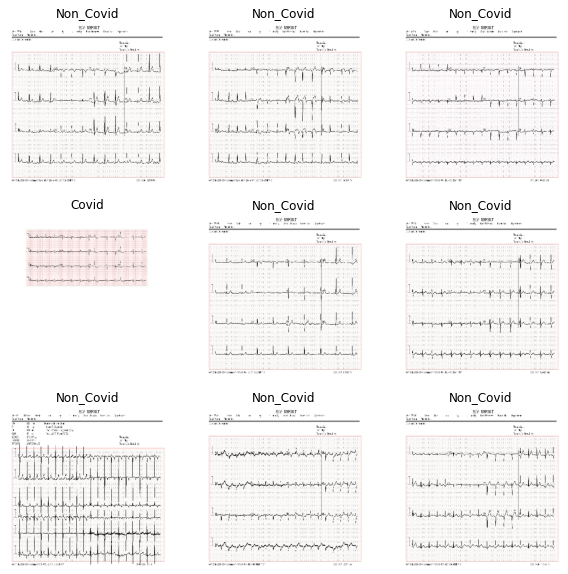

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 360, 360, 3)
(32,)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
val_ds

<PrefetchDataset shapes: ((None, 360, 360, 3), (None,)), types: (tf.float32, tf.int32)>

In [15]:
train_ds

<PrefetchDataset shapes: ((None, 360, 360, 3), (None,)), types: (tf.float32, tf.int32)>

In [16]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [18]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 360, 360, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 360, 360, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 180, 180, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 45, 45, 64)        0

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3))
  ]
)

In [24]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 360, 360, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 360, 360, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 360, 360, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 180, 180, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 180, 180, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 90, 90, 64)       

In [27]:
epochs= 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
49/49 [==============================] - 101s 2s/step - loss: 1.0481 - accuracy: 0.9036 - val_loss: 0.0575 - val_accuracy: 0.9948
Epoch 2/25
49/49 [==============================] - 93s 2s/step - loss: 0.0703 - accuracy: 0.9922 - val_loss: 0.0410 - val_accuracy: 0.9948
Epoch 3/25
49/49 [==============================] - 93s 2s/step - loss: 0.0444 - accuracy: 0.9935 - val_loss: 0.0485 - val_accuracy: 0.9948
Epoch 4/25
49/49 [==============================] - 93s 2s/step - loss: 0.0364 - accuracy: 0.9935 - val_loss: 0.0348 - val_accuracy: 0.9948
Epoch 5/25
49/49 [==============================] - 93s 2s/step - loss: 0.0283 - accuracy: 0.9935 - val_loss: 0.0410 - val_accuracy: 0.9948
Epoch 6/25
49/49 [==============================] - 92s 2s/step - loss: 0.0294 - accuracy: 0.9935 - val_loss: 0.0317 - val_accuracy: 0.9948
Epoch 7/25
49/49 [==============================] - 93s 2s/step - loss: 0.0196 - accuracy: 0.9942 - val_loss: 0.0485 - val_accuracy: 0.9948
Epoch 8/25
49/49 [=

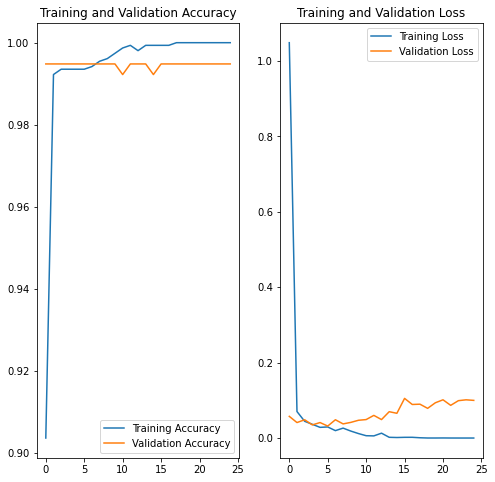

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
for i in os.listdir('All_ECG//ECG_Covid+Cardio'):
    print(i)
    testing_path = f'All_ECG\\ECG_Covid+Cardio\\{i}'
    img = keras.preprocessing.image.load_img(
    testing_path, target_size=(img_height, img_width)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    print('\n')

FileNotFoundError: [Errno 2] No such file or directory: 'All_ECG//ECG_Covid+Cardio'